In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from task_decomposition.analysis.comparisons import (get_subtask_similarity,
                                                     get_IOU,
                                                     get_semantic_distance,
                                                     extract_subtask_from_groundtruth_file,
                                                     extract_subtask_from_LLM_output_file)
from task_decomposition.utils.random_subtask_decomposition import get_random_subtask_decomposition
from task_decomposition.paths import ROBOT_TRAJ_GROUNDTRUTH_DATA_PATH, LLM_OUTPUT_PATH
from task_decomposition.constants import START_STEP_IDX, END_STEP_IDX, DESCRIPTION_IDX, ENVIRONMENT_NAMES

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-02-27 08:25:50.712218: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Helper Functions

In [2]:
def _get_filepaths(env_name: str, llm_model: str, input_mode: str, kind:str) -> list:
    """
    Get the list of groundtruth or LLM output filepaths for a given environment
    """
    if kind == "groundtruth":
        files_path = ROBOT_TRAJ_GROUNDTRUTH_DATA_PATH(env_name)
    elif kind == "llm_output":
        files_path = LLM_OUTPUT_PATH(llm_model, input_mode, env_name)
    else:
        raise ValueError(f"Invalid kind {kind}. Must be either 'groundtruth' or 'llm_outputs'.")
    files = os.listdir(files_path)
    files.remove(".gitkeep") if ".gitkeep" in files else None
    files.remove(".DS_Store") if ".DS_Store" in files else None
    files = [os.path.join(files_path, file) for file in files]
    files = sorted(files)
    return files

### Trajectory Visualization Functions

In [3]:
def format_string(s: list) -> str:
    """
    Add a newline after every 3 words in the list
    """
    N_WORDS_PER_LINE = 3
    x = s.split(" ")
    s_format = []
    for i in range(len(x)):
        s_format.append(x[i])
        s_format.append("\n") if i % N_WORDS_PER_LINE == 0 else None
    return " ".join(s_format)

# Redefine the add_intervals_with_colors function to position the text at the edges
def add_intervals_with_colors(intervals, row, color_map, ax, angle):
    for idx, (start, end, description) in enumerate(intervals):
        color = color_map[0]
        rect_width = end - start if end - start > 0 else 1
        rect = mpatches.Rectangle(
            (start, row), rect_width, 0.8, edgecolor="black", facecolor=color
        )
        ax.add_patch(rect)

        # Position the text at the top and bottom edges of the bars
        if row == 1:  # For the top bar, start the text at the top edge
            text_y = row + 0.8
            va = "bottom"
        else:  # For the bottom bar, start the text at the bottom edge
            text_y = row
            va = "top"

        # Place the text at a 45 degree angle for actual and -45 for predicted
        ax.text(
            (start+end) / 2,
            text_y,
            format_string(description),
            ha="left",
            va=va,
            fontsize="large",
            color="black",
            rotation=angle,
            rotation_mode="anchor",
        )

def plot_trajectory_decomposition(actual, predicted, title, ax=None):
    color_map = ['green', 'blue', 'purple', 'orange', 'red', 'yellow', 'pink', 'brown', 'grey', 'cyan']

    # preprocess so that each subtask in predicted matches the maximum semantic score in actual
    # predicted_color_map = []
    # for p in predicted:
    #     max_score = -1
    #     max_idx = 0
    #     for idx, a in enumerate(actual):
    #         score = semantic_distance(a[2], p[2])
    #         if score >= max_score:
    #             max_score = score
    #             max_idx = idx
    #     predicted_color_map.append(color_map[max_idx])

    # Add actual intervals with color map and angle the text at 45 degrees
    add_intervals_with_colors(actual, 1, color_map, ax, angle=35)

    # Add predicted intervals with color map and angle the text at -45 degrees
    add_intervals_with_colors(predicted, 0, color_map, ax, angle=-35)

    # Set the limits, labels, and title
    ax.set_xlim(-2, max(actual[-1][END_STEP_IDX], predicted[-1][END_STEP_IDX])+5)
    ax.set_ylim(-7, 12)
    ax.set_yticks([0.4, 1.4])
    ax.set_yticklabels(["Predicted", "Ground Truth"], fontsize=12)
    ax.set_xlabel("Step Number")
    ax.set_title(title, fontsize=14)

    plt.tight_layout()
    plt.show()

### Visualize Individual Trajectories

Ground Truth Subtasks: [(0, 11, 'Move to cube'), (12, 13, 'Grasp Cube'), (14, 27, 'Lift Cube')]
LLM Subtasks: [(0, 9, 'robot arm moving towards the cube'), (10, 11, 'robot arm positioning to grip the cube'), (12, 13, 'gripper closing to grip the cube'), (14, 27, 'robot arm lifting the cube')]
Similarity between GT and LLM: {'temporal': 0.8701298701298702, 'semantic': 0.6030883491039276, 'total': 0.736609109616899}


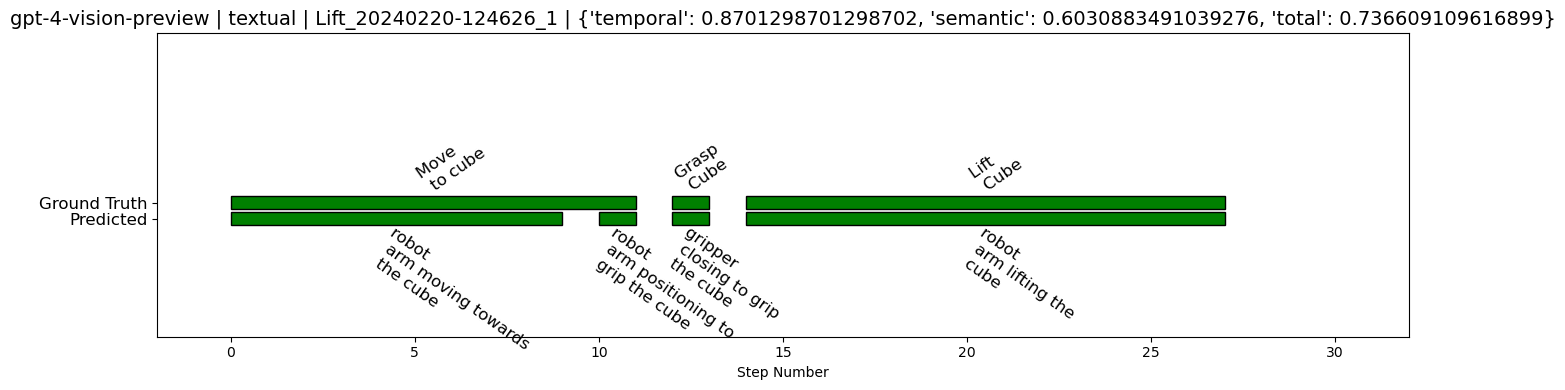

Random Decomposition: [(0, 22, 'Unload objects from a conveyor belt'), (23, 24, 'Unload objects from a truck'), (25, 26, 'Place object on a shelf'), (27, 27, 'Prepare a meal')]
Similarity between GT and Random: {'temporal': 0.32375957375957376, 'semantic': 0.1844489175294127, 'total': 0.25410424564449324}


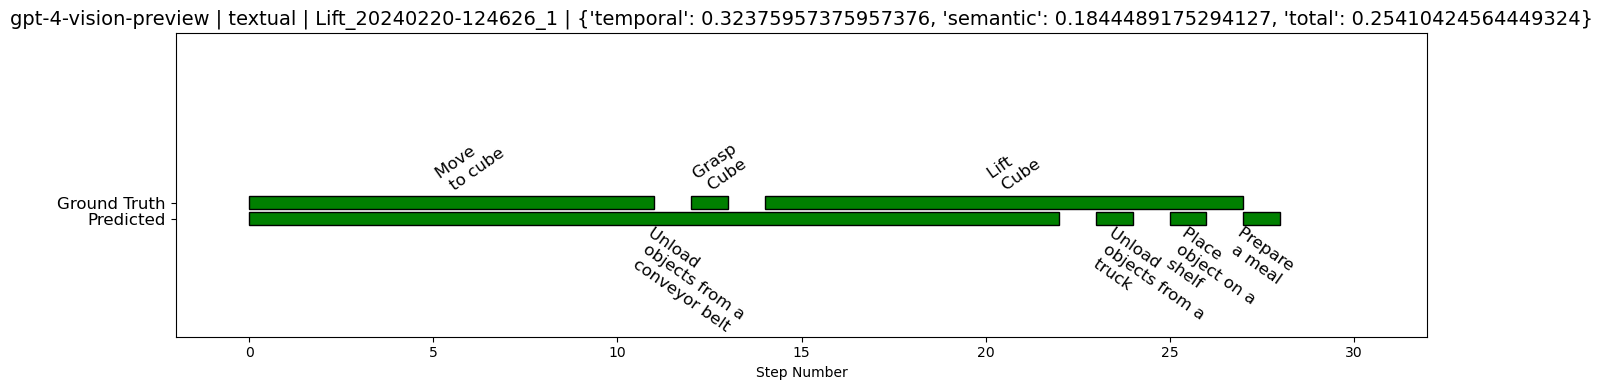

In [7]:
## visualize individual trajectory decompositions
# Example 1
# llm_model = "gpt-4-vision-pro"
# input_mode = "textual"
# env_name = "NutAssemblySquare"
# runid = "NutAssemblySquare_20240225-160456_0"

# Example 2
llm_model = "gpt-4-vision-preview"
input_mode = "textual"
env_name = "Lift"
runid = "Lift_20240220-124626_1"

# Example 3
# llm_model = "video-llava"
# input_mode = "video"
# env_name = "Stack"
# runid = "Stack_20240220-131112_39"


## Extract the groundtruth and LLM output files
gt_file = ROBOT_TRAJ_GROUNDTRUTH_DATA_PATH(env_name)+f"/{runid}_gt.txt"
llm_file = LLM_OUTPUT_PATH(llm_model, input_mode, env_name)+f"/{runid}.json" 

gt_subtasks = extract_subtask_from_groundtruth_file(filepath=gt_file)
llm_subtasks = extract_subtask_from_LLM_output_file(filepath=llm_file,
                                                    llm_model=llm_model)

print(f"Ground Truth Subtasks: {gt_subtasks}")
print(f"LLM Subtasks: {llm_subtasks}")

similarity = get_subtask_similarity(gt_subtasks, llm_subtasks)
print(f"Similarity between GT and LLM: {similarity}")

# # create new figure
fig, ax = plt.subplots(figsize=(14, 4))
title = f"{env_name} Environment, Total{similarity['total']:.2f}, Temporal: {similarity['temporal']:.2f}, Semantic Similarity: {similarity['semantic']:.2f}"
plot_trajectory_decomposition(actual=gt_subtasks,
                              predicted=llm_subtasks, 
                              title=f"{llm_model} | {input_mode} | {runid} | {similarity}", 
                              ax=ax)

random_subtask_decomposition = get_random_subtask_decomposition(gt_subtasks[-1][END_STEP_IDX])
print(f"Random Decomposition: {random_subtask_decomposition}")
similarity = get_subtask_similarity(gt_subtasks, random_subtask_decomposition)
print(f"Similarity between GT and Random: {similarity}")
fig, ax = plt.subplots(figsize=(14, 4))
title = f"{env_name} Environment, Total{similarity['total']:.2f}, Temporal: {similarity['temporal']:.2f}, Semantic Similarity: {similarity['semantic']:.2f}"
plot_trajectory_decomposition(actual=gt_subtasks,
                              predicted=random_subtask_decomposition, 
                              title=f"{llm_model} | {input_mode} | {runid} | {similarity}", 
                              ax=ax)

### Compute Similarity for one Trajectory

In [5]:
runid = "NutAssemblySquare_20240225-160809_17"
# runid = "Stack_20240220-130911_22"
llm_model = "gpt-4-vision-preview"
input_mode = "textual"
env_name = "NutAssemblySquare"
gt_file = ROBOT_TRAJ_GROUNDTRUTH_DATA_PATH(env_name)+f"/{runid}_gt.txt"
llm_file = LLM_OUTPUT_PATH(llm_model, input_mode, env_name)+f"/{runid}.json"
gt_subtasks = extract_subtask_from_groundtruth_file(gt_file)
llm_subtasks = extract_subtask_from_LLM_output_file(filepath=llm_file, 
                                                    llm_model=llm_model)
print(f"Ground Truth Subtasks: {gt_subtasks}")
print(f"LLM Subtasks: {llm_subtasks}")
similarity = get_subtask_similarity(gt_subtasks, llm_subtasks)
print(similarity)

Ground Truth Subtasks: [(0, 63, 'Reach for the Square Nut'), (64, 75, 'Grasp the Square Nut'), (76, 168, 'Align the Square Nut with the Squre Peg'), (169, 173, 'Insert the Square Nut')]
LLM Subtasks: [(0, 0, 'initialize robot arm and gripper'), (1, 1, 'move robot arm slightly'), (2, 2, 'move robot arm while maintaining gripper state'), (3, 3, 'adjust robot arm position'), (4, 4, 'further adjust robot arm position'), (5, 5, 'move robot arm closer to object'), (6, 6, 'move robot arm closer to object with more torque'), (7, 7, 'move robot arm with increased torque and gripper adjustment'), (8, 8, 'adjust robot arm and gripper to align with object'), (9, 9, 'align robot arm with object for grasping'), (10, 10, 'fine-tune robot arm alignment with object'), (11, 11, 'adjust robot arm and gripper for optimal positioning'), (12, 12, 'prepare robot arm for grasping'), (13, 13, 'position robot arm for grasping'), (14, 14, 'move robot arm into grasping position'), (15, 15, 'adjust robot arm for p

### Compute Similarity Metrics in batch by ENV_NAME, INPUT_MODE, LLM_MODEL

In [18]:
def compute_batch_similarity(env_name: str,
                             llm_model: str,
                             input_mode: str,
                             SAVE_OUTPUT: bool = True,
                             verbose: bool = True) -> None:
    """
    Compute the similarity between groundtruth and gpt output files for a given environment.
    """
    gt_files = _get_filepaths(env_name=env_name, 
                                llm_model=llm_model, 
                                input_mode=input_mode, 
                                kind="groundtruth")

    llm_files = _get_filepaths(env_name=env_name, 
                                llm_model=llm_model, 
                                input_mode=input_mode, 
                                kind="llm_output")

    # assert len(gt_files) == len(llm_files), f"The number of groundtruth files {len(gt_files)} and LLM output files {len(llm_files)} are not the same."

    n_runs = len(gt_files)
    output = {"temporal":np.full(n_runs, np.nan), 
              "semantic":np.full(n_runs, np.nan), 
              "total":np.full(n_runs, np.nan)}

    for idx, (gt_file, llm_file) in enumerate(zip(gt_files, llm_files)):
        # make sure we are comparing the same run
        gt_runid = gt_file.split('/')[-1].split('_gt')[0]
        llm_runid = llm_file.split('/')[-1].split('.json')[0]
        assert gt_runid==llm_runid, f"The groundtruth file {gt_file} and llm output file {llm_file} are not from the same run."

        # extract subtasks from groundtruth and gpt output files
        gt_subtasks = extract_subtask_from_groundtruth_file(gt_file)
        llm_subtasks = extract_subtask_from_LLM_output_file(filepath=llm_file, 
                                                            llm_model=llm_model)

        if llm_subtasks == []:    # error with processing the file
            print(f"LLM subtask for {llm_runid} is empty")
            continue

        # compare the subtasks
        try:
            similarity = get_subtask_similarity(gt_subtasks, llm_subtasks)
        except Exception as e:
            print(f"Error with {llm_runid}: {e}")
            continue
        output['temporal'][idx]=similarity["temporal"]
        output['semantic'][idx]=similarity["semantic"]
        output['total'][idx]=similarity["total"]
        if verbose:
            print(f"{gt_runid} and {llm_runid}")
            print(f" Temporal: {similarity['temporal']:.2f} | Semantic: {similarity['semantic']:.2f}")

    # Clean the output in case nans are present
    output['temporal'] = output['temporal'][~np.isnan(output['temporal'])]
    output['semantic'] = output['semantic'][~np.isnan(output['semantic'])]
    output['total'] = output['total'][~np.isnan(output['total'])]

    if SAVE_OUTPUT:
        np.savez(f"{LLM_OUTPUT_PATH(llm_model, input_mode, env_name)}_results.npz", **output)

    print(f" Number of runs: {n_runs}, Number of valid runs: {len(output['total'])}")
    print(f" Temporal: {np.mean(output['temporal']):.2f}+/-{np.std(output['temporal']):.2f} |  Semantic: {np.mean(output['semantic']):.2f}+/-{np.std(output['semantic']):.2f}")

env_names = ENVIRONMENT_NAMES
input_mode = "textual"
# llm_model = "gpt-4-vision-preview"
llm_model = "gemini-pro"
for env_name in env_names:
    print(f"{env_name} environment")
    compute_batch_similarity(env_name=env_name,
                            input_mode=input_mode,
                            llm_model=llm_model,
                            SAVE_OUTPUT=True,
                            verbose=False)


PickPlace environment
Error with PickPlace_20240220-222736_21: Invalid subtask: start index after end index
 Number of runs: 50, Number of valid runs: 49
 Temporal: 0.62+/-0.18 |  Semantic: 0.41+/-0.14


FileNotFoundError: [Errno 2] No such file or directory: '/Users/jonathansalfity/Documents/dev/task_decomposition/task_decomposition/data/gemini-pro_outputs/video/Door_results.npz'

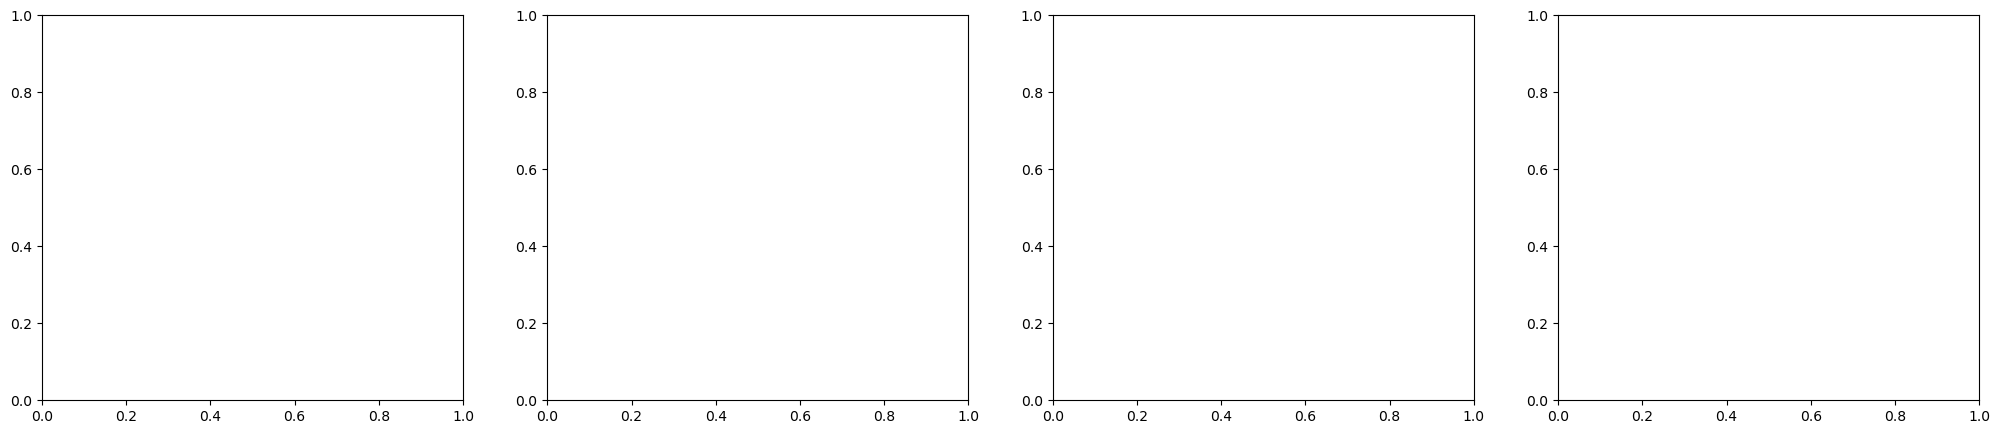

In [34]:
# sns.histplot(data=[temporal, semantic, total], legend=True, kde=True, bins=25)
# env_name = "Door"
# query_type = "video"
# npresultspath = GPT_OUTPUT_PATH+f"/{query_type}/{env_name}" 
# similarity = np.load(f"{npresultspath}_results.npz", allow_pickle=True)
N_BINS = 20
def make_histogram_grid(env_names: list, input_modes: list):
    """
    Create a grid of histograms for the similarity scores between groundtruth and gpt output files.
    Each histogram will show the distribution of the similarity scores for a given environment and query type.
    """
    n_rows = len(input_modes)
    n_cols = len(env_names)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 5*n_rows))
    for i, env_name in enumerate(env_names):
        for j, input_mode in enumerate(input_modes):
            npresultspath = LLM_OUTPUT_PATH(llm_model, input_mode, env_name)
            similarity = np.load(f"{npresultspath}_results.npz", allow_pickle=True)
            temporal = similarity['temporal']
            semantic = similarity['semantic']
            ax = axs[j, i] if n_rows > 1 else axs[i]
            sns.histplot(data=[temporal, semantic], legend=True, bins=N_BINS, ax=ax)
            ax.legend(["Temporal", "Semantic"], loc='upper left')
            ax.set_xlabel('Similarity')
            ax.set_ylabel('Frequency')
            ax.set_xlim(0, 1)
            input_mode = "Text and Video" if input_mode=="textvideo" else input_mode.capitalize()
            ax.set_title(f"{llm_model} {input_mode} | {env_name}, ")

llm_model = "gemini-pro"
envs = ENVIRONMENT_NAMES
input_modes = ["video"]
make_histogram_grid(envs, input_modes)


### Make the rows for the table (LLM_NAME, ENV_NAME, INPUT_MODE, SIMILARITY_METRIC, SIMILARITY_VALUE)

In [16]:
# Make the big table of all the similarity results
llm_model = "gemini-pro"
# input_modes = ["textual", "textualvideo" , "video"]
input_modes = ["textual"]
env_names =  ENVIRONMENT_NAMES
print(llm_model)
print(env_names)
for input_mode in input_modes:
    print(f"{input_mode}: &", end="")
    for env_name in env_names:
        npresultspath =  LLM_OUTPUT_PATH(llm_model, input_mode, env_name)
        similarity = np.load(f"{npresultspath}_results.npz", allow_pickle=True)
        total_mean, total_std = np.mean(similarity['total']), np.std(similarity['total'])
        temporal_mean, temporal_std = np.mean(similarity['temporal']), np.std(similarity['temporal'])
        semantic_mean, semantic_std = np.mean(similarity['semantic']), np.std(similarity['semantic'])
        print(f'${temporal_mean:.2f} \pm {temporal_std:.2f}$ &', end="")
        print(f'${semantic_mean:.2f} \pm {semantic_std:.2f}$ &', end="")

    print('')
    print("______________________________________________________________________")

# Convert to latex:


gemini-pro
['Door', 'Lift', 'PickPlace', 'Stack']
textual: &$0.54 \pm 0.15$ &$0.38 \pm 0.15$ &$0.64 \pm 0.15$ &$0.38 \pm 0.09$ &$nan \pm nan$ &$nan \pm nan$ &$0.48 \pm 0.11$ &$0.31 \pm 0.10$ &
______________________________________________________________________


### Compute Random Baselines for Each Environment

In [9]:
print(ENVIRONMENT_NAMES)
for env_name in ENVIRONMENT_NAMES:
    gt_files = _get_filepaths(env_name=env_name, 
                            llm_model=None, 
                            input_mode=None, 
                            kind="groundtruth")
    # print(f"Env: {env_name}")
    n_runs = len(gt_files)
    output = {"temporal": np.full(n_runs, np.nan), 
              "semantic": np.full(n_runs, np.nan), 
              "total": np.full(n_runs, np.nan)}
    for idx, gt_file in enumerate(gt_files):
        gt_subtask_decomposition = extract_subtask_from_groundtruth_file(gt_file)
        N = gt_subtask_decomposition[-1][END_STEP_IDX]
        random_subtask_decomposition = get_random_subtask_decomposition(N)
        similarity = get_subtask_similarity(gt_subtask_decomposition, 
                                            random_subtask_decomposition)
        temporal = similarity['temporal']
        semantic = similarity['semantic']
        total = similarity['total']
        output['temporal'][idx] = temporal
        output['semantic'][idx] = semantic
        output['total'][idx] = total
        # print(f" Temporal: {temporal:.2f}, Semantic: {semantic:.2f}")

    temporal_mean, temporal_std = np.mean(output['temporal']), np.std(output['temporal'])
    semantic_mean, semantic_std = np.mean(output['semantic']), np.std(output['semantic'])

    print(f'${temporal_mean:.2f} \pm {temporal_std:.2f}$ &', end="")
    print(f'${semantic_mean:.2f} \pm {semantic_std:.2f}$ &', end="")

['Door', 'Lift', 'PickPlace', 'Stack']
$0.35 \pm 0.10$ &$0.23 \pm 0.10$ &$0.44 \pm 0.12$ &$0.23 \pm 0.04$ &$0.36 \pm 0.13$ &$0.19 \pm 0.05$ &$0.32 \pm 0.09$ &$0.19 \pm 0.06$ &